# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Overview

In this project we will look at the Starbucks offer data, explore different offer types, see what a successful offer means for each type, analyse the customer data, and finally use machine learning models to predict offer success rate and what features are more important for predicting an offer's success.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import visuals as vs
import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration and Cleaning

To begin with, we have three files provided. 
- Portfolio- includes information on different starbucks offers
- Profile - Customer demographics- any population that received/viewed/completed the offer
- Transcript - Customer transaction data

We will begin with explorig each of these files to get more information on the data within.

### Portfolio Data

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


From above cell, we can see that there are 10 offers in total, and are categorized into three types, bogo (buy one get one free), discount (discount provided on purchasing), and informational (more about informing about different starbucks products). We can also see that each offer has a validity period (duration), and needs the customer to spend a minimum amount (difficulty), to get the reward. Since teh cell is entire portfolio dataset, we can alse see that there are no null values.

In [3]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Now we have seen the portfolio data, we can see that the channel column is listed. I will separate it out so elements in the list become categorical variables. ThenI will rename id and reward columns to celarly say what they mean. 

In [4]:
portfolio=portfolio.join(portfolio['channels'].str.join('|').str.get_dummies())

In [5]:
portfolio=portfolio.join(portfolio['offer_type'].str.get_dummies())

In [6]:
portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

In [7]:
portfolio = portfolio.rename(columns={"id": "offer_id", 'reward':'totalreward'})

In [8]:
portfolio

,difficulty,duration,offer_id,totalreward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


### Profile Data

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
profile = profile.rename(columns={'id':'Customer_id'})

From above cells we can see that this file contains customer demographics data. We can see that there are some null values associated with gender and income. Before we explore further, lets look at the data distribution by age.

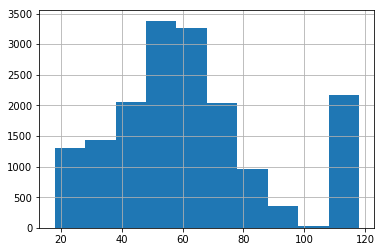

In [12]:
profile.age.hist()

From the above graph, we can there are some outliers. Ages 115 and plus seem to be that outlier category. Let's look at this age category further. 

In [13]:
profile.Customer_id.nunique()

17000

In [14]:
profile[profile['age']>115].Customer_id.nunique()

2175

In [15]:
profile[profile['age']>115].income.sum()

0.0

In [16]:
profile[profile['age']>115].gender

0        None
2        None
4        None
6        None
7        None
9        None
10       None
11       None
17       None
23       None
26       None
36       None
39       None
44       None
45       None
54       None
56       None
57       None
80       None
84       None
96       None
103      None
104      None
108      None
121      None
122      None
128      None
143      None
169      None
172      None
         ... 
16820    None
16829    None
16831    None
16835    None
16839    None
16842    None
16844    None
16845    None
16852    None
16853    None
16856    None
16861    None
16869    None
16875    None
16877    None
16885    None
16906    None
16915    None
16923    None
16931    None
16942    None
16951    None
16953    None
16969    None
16977    None
16980    None
16982    None
16989    None
16991    None
16994    None
Name: gender, Length: 2175, dtype: object

From above cells we can see that ther are 2175 customer profiles (12.8% of total data) that have the outlier age range. We also saw that these rows didn't have gender and income data. These rows do not relay any demographic information we need for data analysis. Hence, I will drop these rows from the dataset.

In [17]:
profile.drop(profile[profile.age >115].index, inplace = True)

In [18]:
profile.Customer_id.nunique()

14825

In [19]:
profile.groupby(['gender']).count()['Customer_id']

gender
F    6129
M    8484
O     212
Name: Customer_id, dtype: int64

In [20]:
profile.drop(profile[profile.gender == 'O'].index, inplace = True)

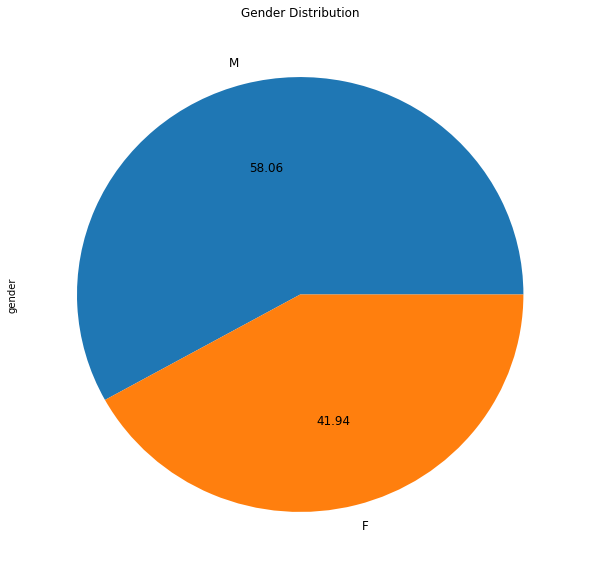

In [21]:
profile.gender.value_counts().plot.pie(figsize=(10, 10), fontsize = 12, autopct = '%.2f', title = 'Gender Distribution')

The above cells show the distribution of data by gender. We see that there are few rows with unknown gender category (less than 2%). Once we drop thsoe rows, we can see that out of the total customer data, 58.06% is male population, and rest 41.94% are females. Now lets explore the income distribution in this group.

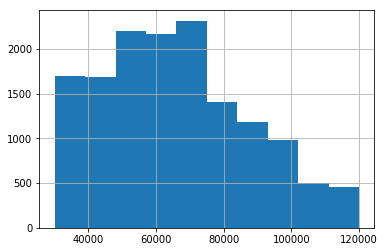

In [22]:
profile.income.hist()

In [23]:
profile.groupby(pd.cut(profile['income'], np.arange(20000, 120000+10000, 10000)))['Customer_id'].count()

income
(20000, 30000]        85
(30000, 40000]      2019
(40000, 50000]      1878
(50000, 60000]      2608
(60000, 70000]      2312
(70000, 80000]      2194
(80000, 90000]      1340
(90000, 100000]     1171
(100000, 110000]     546
(110000, 120000]     460
Name: Customer_id, dtype: int64

In [24]:
profile.income.mean().round(0)

65436.0

In [25]:
profile.groupby(['gender']).agg({'age':'mean', 'income':'mean'}).round(0).rename(columns = {'age':'Average Age', 'income':'Avearge Income'})

,Average Age,Avearge Income
gender,,
F,58.0,71306.0
M,52.0,61195.0


In [26]:
profile.head()

,age,became_member_on,gender,Customer_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


The median income for the entire datset is 65,436, and among female poulation it is $71,306 which is slightly higher compared to males  61,195.

### Transcript Data

In [27]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [28]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [29]:
transcript.shape

(306534, 4)

Transcript data contains information on customer transactions listing out ecah transaction type(receiveed/viewed/transaction/completed). We can also see that offer id related to that particular transaction is listed in the value column. The data needs some preprocessing, like renaming certain columns, converting data in value column into categorical columns. Before proceeding, I want to filter the data to keep only those transactions where customer demographics is available. 

In [30]:
transcript = transcript.rename(columns={'person':'Customer_id'})

In [31]:
select_customers = transcript['Customer_id'].isin(profile['Customer_id'])
transcript = transcript[select_customers]

In [32]:
transcript.shape

(268791, 4)

In [33]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [34]:
transcript.drop(['value'], axis =1, inplace = True)

In [35]:
transcript.head()

,event,Customer_id,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [36]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column  
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

Now I have separated the data in the value column, I want to see if we have offer id information for all the event types.

In [37]:
transcript[transcript['event']=='offer received'].head()

,event,Customer_id,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [38]:
transcript[transcript['event']=='offer viewed'].head()

,event,Customer_id,time,amount,reward,offer_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [39]:
transcript[transcript['event']=='transaction'].head()

,event,Customer_id,time,amount,reward,offer_id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


In [40]:
transcript[transcript['event']=='offer completed'].head()

,event,Customer_id,time,amount,reward,offer_id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,NaN,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0


We can see from above cells, that except for rows that have transaction events, rest of the events have offer ids. We need to get offer ids for transaction rows as well to effectively use this data for analysis.

If an offer has been viewed and then a transaction ahs occurred, we can use the offer id from offer viewed row for that customer and then forwrad fill those ids using ffill function for transaction rows. 

In [41]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offers_view_transacted=transcript[['time','offer_id','Customer_id','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['Customer_id','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

In [42]:
offers_view_transacted.head()

,Customer_id,offer_id,time,event
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,offer viewed
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer viewed
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,offer viewed
12654,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,transaction
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,offer viewed


In [43]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['Customer_id','time','event'])

In [44]:
#clean up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x']).astype(str)

transcript.drop(columns=['offer_id_x','offer_id_y'],inplace=True)

In [45]:
transcript[transcript['event']=='transaction'].head()

,event,Customer_id,time,amount,reward,offer_id
10865,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,ae264e3637204a6fb9bb56bc8210ddfd
10868,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,2906b810c7d4411798c6938adc9daaa5
10870,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,2906b810c7d4411798c6938adc9daaa5
10878,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,ae264e3637204a6fb9bb56bc8210ddfd
10879,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,ae264e3637204a6fb9bb56bc8210ddfd


In [46]:
transcript.shape

(268791, 6)

Now we have filled transcation records with offer ids, the next step is to separate event column into categorical columns, replace any misisng values. Also the time column is in hours, to obtain validity period, we need to compare this column with duration which is in days. To accurately compare them ,we need both the columns in the same format. Therefore, we will convert the time column into days from hours.

In [47]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [48]:
transcript=transcript.join(transcript['event'].str.get_dummies())

In [49]:
transcript.drop(['event'], axis=1, inplace = True)

In [50]:
transcript.fillna(0,inplace=True)

In [51]:
transcript['time'] = transcript['time']/24

In [52]:
transcript.head()

,Customer_id,time,amount,reward,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.0,0.0,3f207df678b143eea3cee63160fa8bed,0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [53]:
transcript.rename(columns={'reward':'reward_received'},inplace=True)

Now the transcript data is ready,I will create a copy of this file to modify and use for the analysis.

In [54]:
offer_data = transcript.copy()

In [55]:
offer_data = offer_data[['Customer_id', 'offer_id','time', 'amount', 'reward_received', 'offer completed',
       'offer received', 'offer viewed', 'transaction']]

In [56]:
offer_data['Customer_and_offer_ids'] = offer_data['Customer_id'] + '/'+ offer_data['offer_id']

In [57]:
offer_data_time = offer_data[offer_data['offer received']==1][['Customer_and_offer_ids','time']]
offer_data_time.rename(columns={'time':'offer_starttime'},inplace=True)
offer_data_time = offer_data_time.groupby(['Customer_and_offer_ids']).agg({'offer_starttime':'mean'})

In [58]:
offer_data = offer_data.merge(offer_data_time, how = 'left', on =['Customer_and_offer_ids'])

In [59]:
offer_data.shape

(268791, 11)

In [60]:
offer_data = offer_data.merge(portfolio, how='left', on = 'offer_id')

In [61]:
offer_data.shape

(268791, 21)

In [62]:
offer_data['within_duration'] = np.logical_and(offer_data['time']>= offer_data['offer_starttime'], offer_data['time']<= (offer_data['offer_starttime'] + offer_data['duration'])).astype(int)

In [63]:
offer_data = offer_data[['Customer_and_offer_ids','Customer_id','offer_id','bogo', 'discount', 'informational','offer_starttime','duration','difficulty','totalreward','email',
       'mobile', 'social', 'web','offer received', 'offer viewed','transaction','offer completed','within_duration','amount','reward_received']]

In [64]:
offer_data.head()

,Customer_and_offer_ids,Customer_id,offer_id,bogo,discount,informational,offer_starttime,duration,difficulty,totalreward,...,mobile,social,web,offer received,offer viewed,transaction,offer completed,within_duration,amount,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef/9b98b8c7a33c4...,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0.0,7,5,5,...,1,0,1,1,0,0,0,1,0.0,0.0
1,e2127556f4f64592b11af22de27a7932/2906b810c7d44...,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0,0.0,7,10,2,...,1,0,1,1,0,0,0,1,0.0,0.0
2,389bc3fa690240e798340f5a15918d5c/f19421c1d4aa4...,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,10.5,5,5,5,...,1,1,1,1,0,0,0,0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d/3f207df678b14...,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,0,1,0.0,4,0,0,...,1,0,1,1,0,0,0,1,0.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1/0b1e1539f2cc4...,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0.0,10,20,5,...,0,0,1,1,0,0,0,1,0.0,0.0


In [65]:
offer_data.shape

(268791, 21)

In [66]:
offer_data['Customer_and_offer_ids'].nunique()

100846

We can see that there are 100,846 unique records based on combined customer and offer ids. We will have to group the data by this column to make sure there are no duplicate rows. After grouping the data, I will filter for only those records that have received the offers as that is the first step for an offer to be successful.

In [67]:
offer_data_grouped = offer_data.groupby(['Customer_and_offer_ids']).agg({'bogo':'mean','discount':'mean','informational':'mean','offer_starttime':'mean','duration':'mean','difficulty':'mean','totalreward':'mean','email':'mean','mobile':'mean', 'social':'mean', 'web':'mean','offer received':'sum', 'offer viewed':'sum','transaction':'sum','offer completed':'sum','within_duration':'sum','amount':'sum','reward_received':'sum' })

In [68]:
offer_data_grouped = offer_data_grouped.reset_index()

In [69]:
offer_data_grouped.head(10)

,Customer_and_offer_ids,bogo,discount,informational,offer_starttime,duration,difficulty,totalreward,email,mobile,social,web,offer received,offer viewed,transaction,offer completed,within_duration,amount,reward_received
0,0009655768c64bdeb2e877511632db8f/0b1e1539f2cc4...,0,1,0,NaN,10,20,5,1,0,0,1,0,0,1,0,0,12.36,0.0
1,0009655768c64bdeb2e877511632db8f/2298d6c36e964...,0,1,0,NaN,7,7,3,1,1,1,1,0,0,1,0,0,14.11,0.0
2,0009655768c64bdeb2e877511632db8f/2906b810c7d44...,0,1,0,24.0,7,10,2,1,1,0,1,1,0,2,1,4,28.68,2.0
3,0009655768c64bdeb2e877511632db8f/3f207df678b14...,0,0,1,14.0,4,0,0,1,1,0,1,1,1,0,0,2,0.00,0.0
4,0009655768c64bdeb2e877511632db8f/5a8bc65990b24...,0,0,1,7.0,3,0,0,1,1,1,0,1,1,1,0,2,8.57,0.0
5,0009655768c64bdeb2e877511632db8f/9b98b8c7a33c4...,1,0,0,NaN,7,5,5,1,1,0,1,0,0,1,0,0,28.16,0.0
6,0009655768c64bdeb2e877511632db8f/f19421c1d4aa4...,1,0,0,17.0,5,5,5,1,1,1,1,1,1,1,1,3,22.16,5.0
7,0009655768c64bdeb2e877511632db8f/fafdcd668e374...,0,1,0,21.0,10,10,2,1,1,1,1,1,1,1,1,4,13.56,2.0
8,0020c2b971eb4e9188eac86d93036a77/2906b810c7d44...,0,1,0,NaN,7,10,2,1,1,0,1,0,0,1,0,0,33.86,0.0
9,0020c2b971eb4e9188eac86d93036a77/3f207df678b14...,0,0,1,NaN,4,0,0,1,1,0,1,0,0,3,0,0,75.80,0.0


In [70]:
offer_data_grouped.shape

(100846, 19)

In [71]:
offer_data_grouped['offer_successful']=np.logical_or(np.logical_and(offer_data_grouped['informational'] ==1,offer_data_grouped['within_duration']>=3).astype(int), (offer_data_grouped['within_duration']>=4).astype(int)).astype(int)

In [72]:
offer_received_data = offer_data_grouped[(offer_data_grouped['offer received'] == 1)]

In [73]:
offer_received_data[['Customer_id','offer_id']] = offer_received_data['Customer_and_offer_ids'].str.split('/',expand=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [74]:
offer_received_data = offer_received_data.drop(columns ="Customer_and_offer_ids")

In [75]:
offer_received_data = offer_received_data[['Customer_id',
       'offer_id','bogo', 'discount', 'informational', 'offer_starttime', 'duration',
       'difficulty', 'totalreward', 'email', 'mobile', 'social', 'web',
       'offer received', 'offer viewed', 'transaction','offer completed', 'within_duration',
       'amount', 'reward_received', 'offer_successful']]

In [76]:
offer_received_data.shape

(44412, 21)

Now I have grouped and filtered the offer data, I will merge it with profile data to obtain customer demographics. 

In [77]:
new_dataset = offer_received_data.merge(profile, how='left', on = 'Customer_id')

In [78]:
new_dataset.shape

(44412, 25)

In [79]:
new_dataset.head()

,Customer_id,offer_id,bogo,discount,informational,offer_starttime,duration,difficulty,totalreward,email,...,transaction,offer completed,within_duration,amount,reward_received,offer_successful,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0,24.0,7,10,2,1,...,2,1,4,28.68,2.0,1,33,20170421,M,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,0,1,14.0,4,0,0,1,...,0,0,2,0.00,0.0,0,33,20170421,M,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,0,1,7.0,3,0,0,1,...,1,0,2,8.57,0.0,0,33,20170421,M,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,17.0,5,5,5,1,...,1,1,3,22.16,5.0,0,33,20170421,M,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,21.0,10,10,2,1,...,1,1,4,13.56,2.0,1,33,20170421,M,72000.0


In [80]:
new_dataset = new_dataset[['Customer_id', 'age', 'became_member_on', 'gender', 'income','offer_id', 'bogo', 'discount', 'informational',
       'offer_starttime', 'duration', 'difficulty', 'totalreward', 'email',
       'mobile', 'social', 'web', 'offer received', 'offer viewed','transaction',
       'offer completed', 'within_duration', 'amount', 'reward_received',
       'offer_successful']]

In the merged data we have information on when the customer has become member of Starbucks, we can get memebrship stenure from this column to see if this feature has any effect on offer's success rate. I will then groupby this data based on offer's succcessfulness and gender to see the distribution of customer demographics.

In [81]:
new_dataset['became_member_on'] = pd.to_datetime(new_dataset['became_member_on'], format ='%Y%m%d')


In [82]:
new_dataset['today'] = pd.to_datetime('today').strftime('%Y%m%d')
new_dataset['today'] =  pd.to_datetime(new_dataset['today'], format ='%Y%m%d')
new_dataset['membership_tenure'] = ((new_dataset['today']) - (new_dataset['became_member_on'])).dt.days

In [83]:
new_dataset.drop(['became_member_on', 'today','within_duration'],axis =1, inplace = True)

In [84]:
new_dataset.head()

,Customer_id,age,gender,income,offer_id,bogo,discount,informational,offer_starttime,duration,...,social,web,offer received,offer viewed,transaction,offer completed,amount,reward_received,offer_successful,membership_tenure
0,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,24.0,7,...,0,1,1,0,2,1,28.68,2.0,1,916
1,0009655768c64bdeb2e877511632db8f,33,M,72000.0,3f207df678b143eea3cee63160fa8bed,0,0,1,14.0,4,...,0,1,1,1,0,0,0.00,0.0,0,916
2,0009655768c64bdeb2e877511632db8f,33,M,72000.0,5a8bc65990b245e5a138643cd4eb9837,0,0,1,7.0,3,...,1,0,1,1,1,0,8.57,0.0,0,916
3,0009655768c64bdeb2e877511632db8f,33,M,72000.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,17.0,5,...,1,1,1,1,1,1,22.16,5.0,0,916
4,0009655768c64bdeb2e877511632db8f,33,M,72000.0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,21.0,10,...,1,1,1,1,1,1,13.56,2.0,1,916


In [85]:
new_dataset.groupby(['gender','offer_successful']).agg({'Customer_id':'count','age':'mean','income':'mean','membership_tenure':'mean'}).round(0).rename(columns={'Customer_id':'Customer Count','age':'Average Age','income':'Average Income'})

Customer Count  Average Age  Average Income  \
gender offer_successful                                                
F      0                          14817         58.0         71880.0   
       1                           3789         56.0         68595.0   
M      0                          21093         52.0         61335.0   
       1                           4713         52.0         61239.0   

                         membership_tenure  
gender offer_successful                     
F      0                             941.0  
       1                            1064.0  
M      0                             950.0  
       1                            1133.0

From the above cell we can see the following trends:

- Offer Successful (value = 1)
    - Almost 20% of the offers were successful. i.e these records have all the events necessary for it be called successful (offer received -> offer viewed -> transaction -> offer completed - all within offer validity period). 
    - Out of this 45% of the transcations were from female customers and rest 55% from male customers
    - The average age and income of female customers is 56 and 68k respectively, and have membership tenure of more than 1000 days
    - The average age and income of male customers is 52 and 61k, and have membership tenure of more than 1100 days
    
- Offer Unsuccessful (value = 0)
    - Almost 80% of the offers were unsuccessful. i.e these records did not have all the events necessary for it be called successful (offer received -> offer viewed -> transaction -> offer completed). They fell into one of the following categories
        - They viewed and completed the offer but not within offer validity period
        - They did not view the offer but completed it (unaware of the offer)
        - They viewed the offer but didn't complete it
        - They received the offer but didn't atke any further action
    
    - Out of this 41% of the transcations were from female customers and rest 59% from male customers
    - The average age and income of female customers is 58 and 71k respectively, and have membership tenure of more than 930 days
    - The average age and income of male customers is 52 and 61k, and have membership tenure of more than 940 days
 
- General observation
     - There were more offers received by male customers (58%) than female (42%). 
     - Out of all offers received by male customers only 18% were successful, and for feamles 20% were successful.

I would now like to see if there is any change in the trend if the dataset is separated by offer type.

In [86]:
bogo_data = new_dataset[new_dataset['bogo'] ==1]
discount_data = new_dataset[new_dataset['discount'] ==1]
info_data = new_dataset[new_dataset['informational'] ==1]

In [87]:
bogo_data.groupby(['gender','offer_successful']).agg({'Customer_id':'count','age':'mean','income':'mean','membership_tenure':'mean'}).round(0).rename(columns={'Customer_id':'Customer Count','age':'Average Age','income':'Average Income'})

Customer Count  Average Age  Average Income  \
gender offer_successful                                                
F      0                           5782         58.0         71704.0   
       1                           1634         56.0         68770.0   
M      0                           8482         52.0         61042.0   
       1                           1877         52.0         62054.0   

                         membership_tenure  
gender offer_successful                     
F      0                             939.0  
       1                            1067.0  
M      0                             951.0  
       1                            1123.0

In [88]:
discount_data.groupby(['gender','offer_successful']).agg({'Customer_id':'count','age':'mean','income':'mean','membership_tenure':'mean'}).round(0).rename(columns={'Customer_id':'Customer Count','age':'Average Age','income':'Average Income'})

Customer Count  Average Age  Average Income  \
gender offer_successful                                                
F      0                           5812         58.0         71876.0   
       1                           1629         56.0         68824.0   
M      0                           8278         52.0         61463.0   
       1                           2049         52.0         61639.0   

                         membership_tenure  
gender offer_successful                     
F      0                             939.0  
       1                            1070.0  
M      0                             944.0  
       1                            1140.0

Looks like majority of the records fell into offer types bogo or discount. From above two cells, we can see that they have very similar trend, and mirrors with the trends of entire dataset (all offers combined)

- Overall 20% of the offers received were successful 
- More offers received by males (58%) than females (42%)
- 22% of offers received by females were successful while for males it was only 18-20%


In [89]:
info_data.groupby(['gender','offer_successful']).agg({'Customer_id':'count','age':'mean','income':'mean','membership_tenure':'mean'}).round(0).rename(columns={'Customer_id':'Customer Count','age':'Average Age','income':'Average Income'})

Customer Count  Average Age  Average Income  \
gender offer_successful                                                
F      0                           3223         57.0         72201.0   
       1                            526         57.0         67344.0   
M      0                           4333         53.0         61665.0   
       1                            787         51.0         58254.0   

                         membership_tenure  
gender offer_successful                     
F      0                             951.0  
       1                            1032.0  
M      0                             958.0  
       1                            1140.0

For informational offers

- Overall almost 15% of the offers were successful (people successfully viewed those offers and made a transaction within validity period)
- More offers received by males (58%) than females (42%)
- 14% of offers received by females were successful while for males it was 15%
- Slightly lower success rate with informational offers compared to bogo or discount maybe attributable to the lack of reward on informational offers

## Data Modeling

Before proceeding with machine learning models, I want to evaluate the performance using Naive Predictor.

#### Naive Predictor Performace
* Naive predictor would always assume that an offer is successful. It would be interesting to see the model's accuracy and F-score on this data using naive predictor. 
* In this model there will be no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives(TP) + False Positives(FP))) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives (TP) + False Negatives(FN))) in this setting becomes 1 as we have no False Negatives.

In [90]:
# Naive Predictor
offer_successful = new_dataset['offer_successful']

TP = np.sum(offer_successful)
print(TP)

FP = offer_successful.count() - TP
print(FP)

TN = 0
FN = 0

# Calculate accuracy, precision and recall
accuracy = TP/ (TP+FP+TN+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+(0.5**2))*(precision *recall)/(((0.5**2)*precision)+ recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f} ]".format(accuracy, fscore, precision, recall))

8502
35910
Naive Predictor: [Accuracy score: 0.1914, F-score: 0.2284, Precision: 0.1914, Recall: 1.0000 ]


Now, we will use other machine learning algorithms to determine which is best at modleing the offer data. Since this is a classification scenario, the three models I chose are RandomForest, AdaBoost, and GradientBoosting. 

#### Other Models
Model 1 - RandomForestClassifier() 
- Real world application: Any classificatiion problems/scenarios, for example classifying email as spam, identifying the best app to download or a fraudulent activity, predicting disease, remote sensing.
- Strengths: it takes average of all predictions (ensemble of trees based on random set of data), therefore no overfitting. Best used when the data is large and versatile to get more accurate predictions.
- Weaknesses: Time consuming as the model has to construct multiple decsision trees and then vote on it. might not be best in situations where run-time performance is important.
- Suitable model for the offer data as we are focussed on identifying the potential customers (classification scenario) and large data set.

Model 2 - AdaBoostClassifier() 
- Real world application: Any classificatiion problems/scenarios, for example classifying email as spam, identifying the best app to download or a fraudulent activity, predicting diseases, face recognition.
- Strengths: converts all weak learners to strong ones by assigning higher weights so the misclassified data gets correctly classified on next itreration. Minimum error, doesn't overfit, and high accuracy or predictive power. 
- Weaknesses: sensistive to noisy data, and outliers(tries to fit every point in the model) affecting model's performance
- Relativeley large data set. Since the goal of the project is to identify if an offer will be succesful or not; a binary classification scenario,  adaboost model will perform really well. 
    
Model 3 - GradientBoostingClassifier() 
- Real world application: Any classificatiion problems/scenarios, for example classifying email as spam, identifying the best app to download or a fraudulent activity, predicting diseases, classifying credit defaults.
- Strengths: High predictive power, robustness to outliers, performs well with heterogenous data
- Weaknesses: Scalability.
- Since the focus of the project is to predict wth higher accuracy and also the data has many features gradient boosting will yield better results 

In [91]:
# Split the data into features and target label
def features_and_target(data):
    #features - the features in the dataset that we wil use to predict our target. Here it is named as other_features
    #target - the column or feature we are trying to predict use ML model. Our target here is to predict is offer's success rate
    offer_successful = data['offer_successful']
    other_features = data.drop(['offer_successful','Customer_id','offer_id','amount'], axis = 1)
    # Log-transform the skewed features
    skewed = ['income']
    features_log_transformed = pd.DataFrame(data = other_features)
    features_log_transformed[skewed] = other_features[skewed].apply(lambda x: np.log(x + 1))
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['age', 'income', 'offer_starttime', 'duration', 'difficulty','reward_received','totalreward']

    features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
    features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])
    features_final = pd.get_dummies(features_log_minmax_transform)
    
    encoded = list(features_final.columns)
    print (encoded)
    # Split the 'features' and 'income' data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    offer_successful, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    
    return X_train, X_test, y_train, y_test

In [92]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    sample_size = int(sample_size)
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    from sklearn.metrics import fbeta_score
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

## Combined Data (all offers combined) Model

In [93]:
X_train, X_test, y_train, y_test = features_and_target(new_dataset)

['age', 'income', 'bogo', 'discount', 'informational', 'offer_starttime', 'duration', 'difficulty', 'totalreward', 'email', 'mobile', 'social', 'web', 'offer received', 'offer viewed', 'transaction', 'offer completed', 'reward_received', 'membership_tenure', 'gender_F', 'gender_M']
Training set has 35529 samples.
Testing set has 8883 samples.


RandomForestClassifier trained on 355 samples.
RandomForestClassifier trained on 3552 samples.
RandomForestClassifier trained on 35529 samples.
AdaBoostClassifier trained on 355 samples.
AdaBoostClassifier trained on 3552 samples.
AdaBoostClassifier trained on 35529 samples.
GradientBoostingClassifier trained on 355 samples.
GradientBoostingClassifier trained on 3552 samples.
GradientBoostingClassifier trained on 35529 samples.


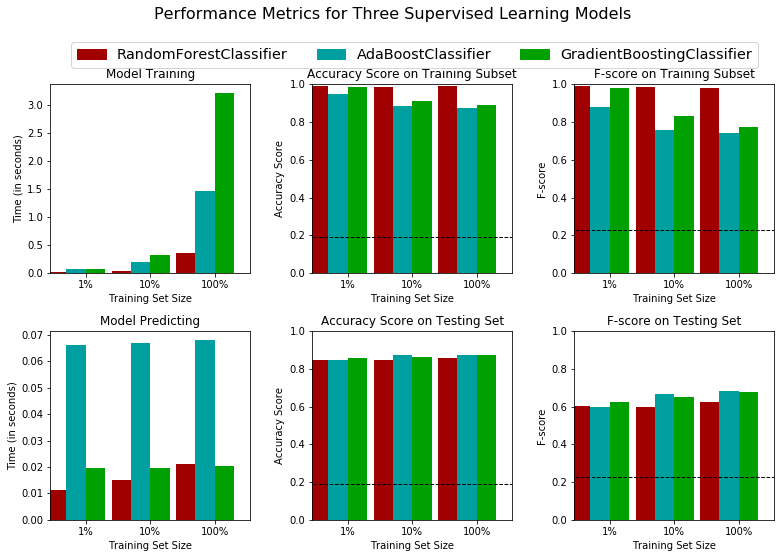

In [94]:
# Initialize the three models
clf_A = RandomForestClassifier(random_state = 10)
clf_B = AdaBoostClassifier(random_state = 10)
clf_C = GradientBoostingClassifier(random_state = 10)



# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

Based on the results from above, the best model GradientBoostingClassifier due to the following factors:

- Metrics - Fscore on testing set when 100% of training data is used is more or less same for AdaBoost and GradientBoosting models. 
- Predicting/training time was the shortest for GradientBoosting while it was longest for AdaBoost
- Due to its high predictive power, it's robustness to outliers, ability to handle heterogenous data, and relatively small training time, GradientBoosting seems to be the best model to predict offer success rate.

In [95]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[90]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8731
Precision score on testing data: 0.7004
Recall score on testing data: 0.5951
F-score on testing data: 0.6765

Optimized Model
------
Final accuracy score on the testing data: 0.8738
Final precision score on the testing data: 0.7033
Final recall score on the testing data: 0.5951
Final F-score on the testing data: 0.6786


- Optimized model's accuarcy and fscores on testing data were 0.8738 and 0.6786 respectively.
- Both accuarcy and fscores were slightly higher for optimized model than unoptimized model for testing data.
- Compared to the naive predictor benchmarks the accuarcy score (0.1914) and fscore (0.2284) the optimized models scores were way higher indicating the model's high performance and efficiency. 

### Feature Importance

This particular task allows us to identify the features with most predictive power in the dataset, i.e the features that have most impact on offer's success. My goal here is to identify top 10 features that affect the offer's success. 

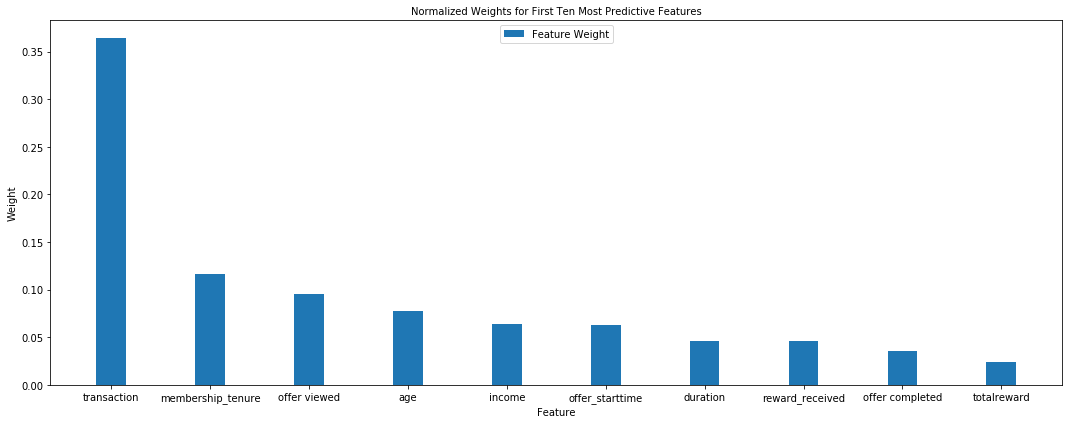

In [96]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

From the above graph, we can see that for combined dataset, transaction is the most important feature. If a customer performs a transaction, then the offer is most likey to be successful. Apart from transaction customer features that have an impact on offer's success are customer's membership tenure, age, and income. 

## BOGO Model (includes only bogo offer data)

In [97]:
X_train, X_test, y_train, y_test = features_and_target(bogo_data)

['age', 'income', 'bogo', 'discount', 'informational', 'offer_starttime', 'duration', 'difficulty', 'totalreward', 'email', 'mobile', 'social', 'web', 'offer received', 'offer viewed', 'transaction', 'offer completed', 'reward_received', 'membership_tenure', 'gender_F', 'gender_M']
Training set has 14220 samples.
Testing set has 3555 samples.


RandomForestClassifier trained on 142 samples.
RandomForestClassifier trained on 1422 samples.
RandomForestClassifier trained on 14220 samples.
AdaBoostClassifier trained on 142 samples.
AdaBoostClassifier trained on 1422 samples.
AdaBoostClassifier trained on 14220 samples.
GradientBoostingClassifier trained on 142 samples.
GradientBoostingClassifier trained on 1422 samples.
GradientBoostingClassifier trained on 14220 samples.


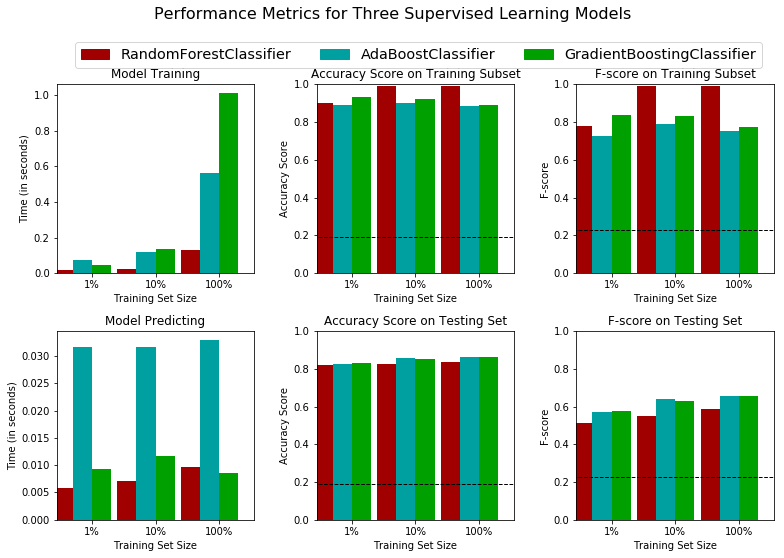

In [98]:
# Initialize the three models
clf_A = RandomForestClassifier(random_state = 10)
clf_B = AdaBoostClassifier(random_state = 10)
clf_C = GradientBoostingClassifier(random_state = 10)



# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [99]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[80]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8599
Precision score on testing data: 0.6821
Recall score on testing data: 0.5592
F-score on testing data: 0.6534

Optimized Model
------
Final accuracy score on the testing data: 0.8619
Final precision score on the testing data: 0.6904
Final recall score on the testing data: 0.5592
Final F-score on the testing data: 0.6595


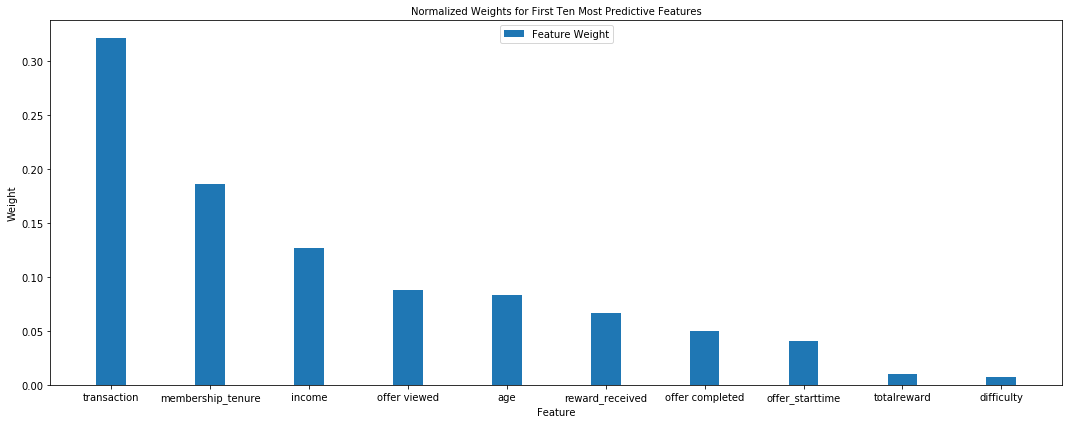

In [100]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

## Discount Model (includes only discount offer data)

In [101]:
X_train, X_test, y_train, y_test = features_and_target(discount_data)

['age', 'income', 'bogo', 'discount', 'informational', 'offer_starttime', 'duration', 'difficulty', 'totalreward', 'email', 'mobile', 'social', 'web', 'offer received', 'offer viewed', 'transaction', 'offer completed', 'reward_received', 'membership_tenure', 'gender_F', 'gender_M']
Training set has 14214 samples.
Testing set has 3554 samples.


RandomForestClassifier trained on 142 samples.
RandomForestClassifier trained on 1421 samples.
RandomForestClassifier trained on 14214 samples.
AdaBoostClassifier trained on 142 samples.
AdaBoostClassifier trained on 1421 samples.
AdaBoostClassifier trained on 14214 samples.
GradientBoostingClassifier trained on 142 samples.
GradientBoostingClassifier trained on 1421 samples.
GradientBoostingClassifier trained on 14214 samples.


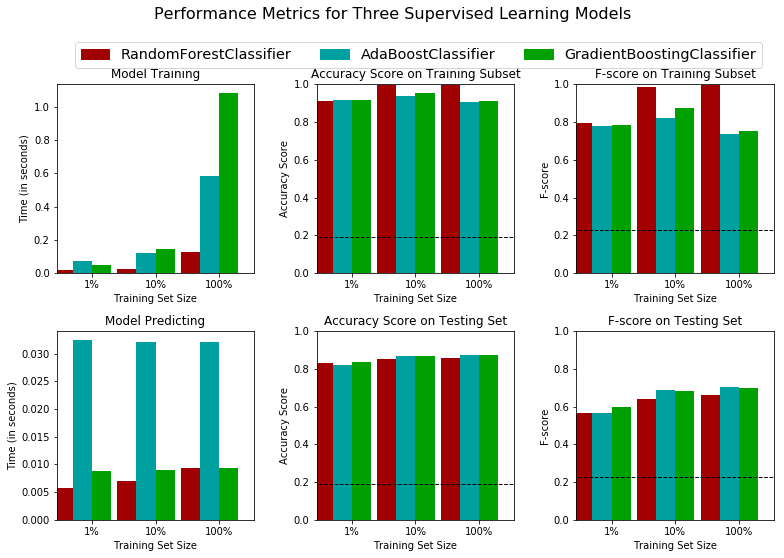

In [102]:
# Initialize the three models
clf_A = RandomForestClassifier(random_state = 10)
clf_B = AdaBoostClassifier(random_state = 10)
clf_C = GradientBoostingClassifier(random_state = 10)



# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [103]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[80]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8748
Precision score on testing data: 0.6946
Recall score on testing data: 0.7087
F-score on testing data: 0.6973

Optimized Model
------
Final accuracy score on the testing data: 0.8756
Final precision score on the testing data: 0.7022
Final recall score on the testing data: 0.6965
Final F-score on the testing data: 0.7010


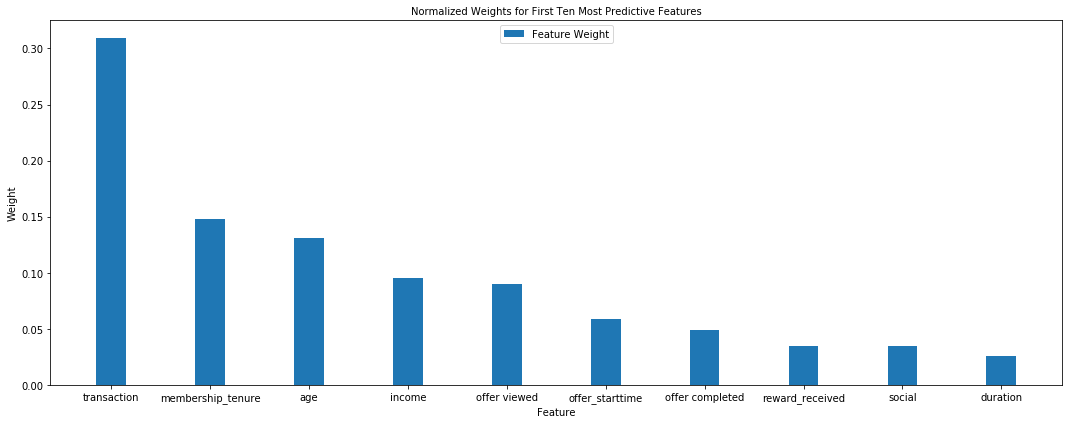

In [104]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

## Info Model (includes only informational offer data)

In [105]:
X_train, X_test, y_train, y_test = features_and_target(info_data)

['age', 'income', 'bogo', 'discount', 'informational', 'offer_starttime', 'duration', 'difficulty', 'totalreward', 'email', 'mobile', 'social', 'web', 'offer received', 'offer viewed', 'transaction', 'offer completed', 'reward_received', 'membership_tenure', 'gender_F', 'gender_M']
Training set has 7095 samples.
Testing set has 1774 samples.


RandomForestClassifier trained on 70 samples.
RandomForestClassifier trained on 709 samples.
RandomForestClassifier trained on 7095 samples.
AdaBoostClassifier trained on 70 samples.
AdaBoostClassifier trained on 709 samples.
AdaBoostClassifier trained on 7095 samples.
GradientBoostingClassifier trained on 70 samples.
GradientBoostingClassifier trained on 709 samples.
GradientBoostingClassifier trained on 7095 samples.


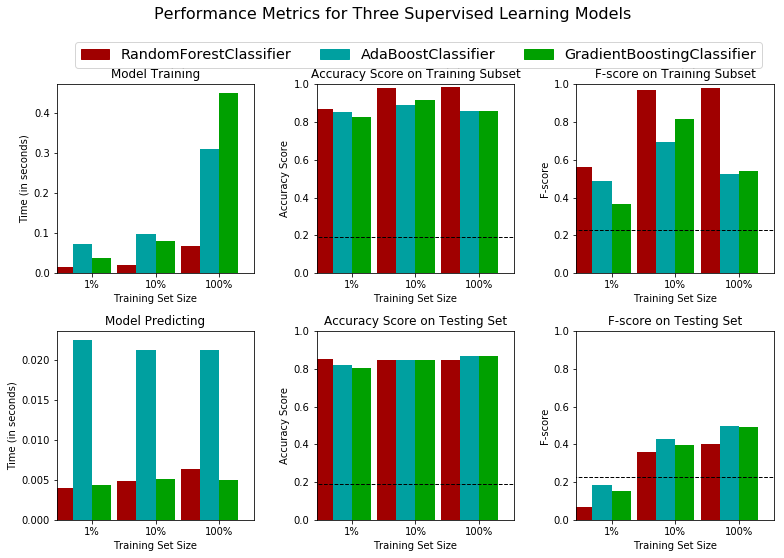

In [106]:
# Initialize the three models
clf_A = RandomForestClassifier(random_state = 10)
clf_B = AdaBoostClassifier(random_state = 10)
clf_C = GradientBoostingClassifier(random_state = 10)



# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [107]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[80]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8658
Precision score on testing data: 0.6306
Recall score on testing data: 0.2622
F-score on testing data: 0.4923

Optimized Model
------
Final accuracy score on the testing data: 0.8670
Final precision score on the testing data: 0.6505
Final recall score on the testing data: 0.2509
Final F-score on the testing data: 0.4934


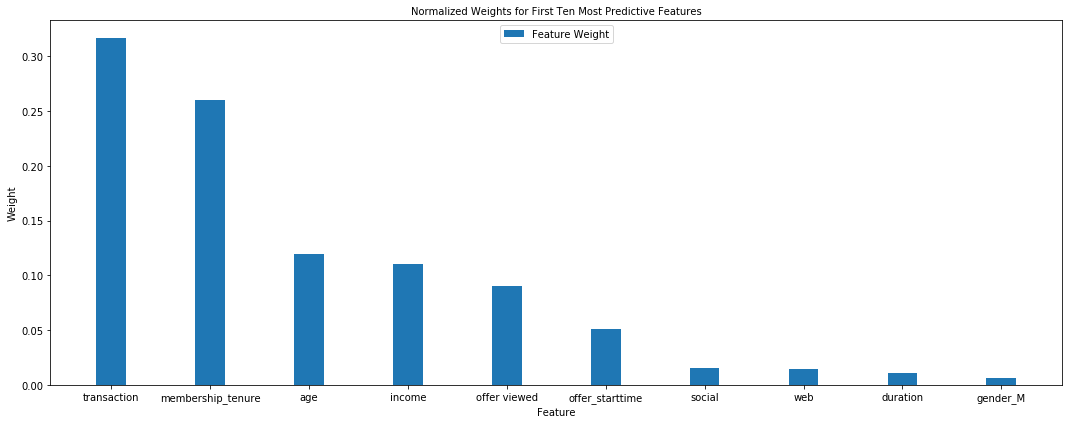

In [108]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

The model results are more or less similar or combined dataset and individual offer based datasets. We can see that overall completing a transcation is crucial step for an offer's success. Regarding customer demographics, customer's membership tenure, age, and income play a cruicial role. Longer the customer's membership tenure more likey they are to respond to  an offer. For informational offers, the source of information also seems to have more value add. People who received the information through social media are more likely to respond to the offer. 

## Conclusion

My main focus in this project was defining a successful offer, and what features in the dataset have a high impact on offer's success.In the process I had to clean and process data, drop any outliers, or missing information that didn't add any value to the anlaysis. Since i wnated to evaluate an offer's success, I used RandomForest, AdaBoost, and GradientBoosting clasisfiers for my models, and chose the GradientBoosting as my final model due to it's high accuracy and f score on test data and shorter training time.

In general the observations were as follows:

- Among the people who received an offer, there was larger percentage of male population (58%) compared to females (42%).
- Offer's success percent was slightly higher among females (20%) compared to males(18%), although for informational offers male population responded slightly better than females.
- Most of the offers were either bogo or discount, and few informational
- Success percent was slightly higher for bogo and discount offers (20%) compared to informational (15%) which might be attributable to reward associated with bogo/discount offers
- Accuracy score with GradientBoosting classifier on combined dataset (includes all offer types) was 0.8738, and fscore was 0.6786 and scores were way better than naive predictor performance. This shows higher efficiency in using GradientBoosting model
- Features that had most impact on offer's success were - transaction (customer makes a transaction), customer's membership tenure, age, income, and rewrad received on completing the offer.

Future Improvements :

- Analyze results including the values that were dropped (ex - customers with no gender/ income information)
- Analyze customer transaction data further to see how much a customer would spend
- See if other machine learning models have an impact on the predicting power (like linear regression/decision tree)
